### Steps to take
step 1: Import all the necessary python packages<br>
step 2: Obtain and clean data <br>
step 3: Data Exploration <br>
step 4: Modify data for Machine Learning<br>
step 5: Get dummies<br>
step 6: SMOTH<br>
step 5: Split data inot train and test<br> 
step 6: standard scaling<br>
step 7: logistic regression<br>
step 8: parameter tuning<br>
step 9: provide actionable recommendations<br>

### Questions
1. When to apply get_dummies: before or after train-test split?
2. Do we need to worry about data leakage when doing CV? (See Medium article above)
3. Which one comes first - cost minimization or parameter tuning (C value)?
4. When to deal with imbalanced dataset? (For now we use class_weight='balanced' in sklearn LogReg)
5. Logistic_Regression solvers ‘liblinear’, ‘lbfgs’, and ‘newton-cg’ are "robust to unscaled datasets". Does this mean we don't have to scale our data??? (Note: ‘lbfgs’, and ‘newton-cg’ support no penalty (vanilla) and L2 penalty. For L1 penalty use 'saga' (which is **not** robust to unscaled datasets)

# Predicting Successful Bank Phone Campaign 

### Mod 3 Project for FIS DC DS 08262019

### Collaborators:
- **Sisay Filate**
- **Anastasia Kharina**
  

### Goals:

Predicts the outcome of a direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe to a cash investment for an agreed rate of interest over a fixed amount of time, or term. <br>
<br>
To achieve this goal, we perform logistic regression. Logistic Regression is a predictive Machine Learning classification algorithm that explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.<br>


### Data Source

We used [Bank Marketing Data Set](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) from UCI Machine Learning Repository




## Step 1: Import all the necessory python packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=14)
import seaborn as sns 
# sns.set(style='white')
# sns.set(style='whitegrid', color_codes=True)

#Machine Learning Modules
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix#, classifiction_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# autoreload 
%load_ext autoreload
%autoreload 2

## Step 2: Obtain and clean data

In [2]:
bank = pd.read_csv('data/bank-additional-full.csv', sep=';')

print(f"The dataset contains {bank.shape[0]} records and {bank.shape[1]} features.")
print(f"There are {bank.isna().sum().sum()} null values in the dataset")

bank.head()
bank.columns

The dataset contains 41188 records and 21 features.
There are 0 null values in the dataset


Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

##### Cleaning data:
- Remove duplicates
- Reclassify "education" from 8 into 5 tiers
- Adding "season" feature
- Select only interesting features
- Add "data/clean_data.csv" file

In [3]:
import data_cleaning 
bank_clean = data_cleaning.cleaned_data(bank)
print(f"The dataset contains {bank_clean.shape[0]} records and {bank_clean.shape[1]} features.")
bank_clean.head()

There were 12 duplicates and they have been removed
The dataset contains 41176 records and 14 features.


,age,job,marital,education,default,housing,loan,contact,season,day_of_week,campaign,previous,poutcome,target
0,56,housemaid,married,basic,no,no,no,telephone,spring,mon,1,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,spring,mon,1,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,spring,mon,1,0,nonexistent,0
3,40,admin.,married,basic,no,no,no,telephone,spring,mon,1,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,spring,mon,1,0,nonexistent,0


### Input variables explanation (from [source](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing))
1. age (numeric)
2. job : type of job (categorical: “admin”, “blue-collar”, “entrepreneur”, “housemaid”, “management”, “retired”, “self-employed”, “services”, “student”, “technician”, “unemployed”, “unknown”)
3. marital : marital status (categorical: “divorced”, “married”, “single”, “unknown”)
4. education (categorical: “basic”, “high.school”, “illiterate”, “professional.course”, “university.degree”, “unknown”)
5. housing: has housing loan? (categorical: “no”, “yes”, “unknown”)
6. loan: has personal loan? (categorical: “no”, “yes”, “unknown”)
7. contact: contact communication type (categorical: “cellular”, “telephone”)
8. month: last contact month of year (categorical: “jan”, “feb”, “mar”, …, “nov”, “dec”)
9. day_of_week: last contact day of the week (categorical: “mon”, “tue”, “wed”, “thu”, “fri”)
10. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model
11. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
12. previous: number of contacts performed before this campaign and for this client (numeric)
13. poutcome: outcome of the previous marketing campaign (categorical: “failure”, “nonexistent”, “success”)

#### Predict variable (desired target):
target — has the client subscribed a term deposit? (binary: “1”, means “Yes”, “0” means “No”)


## Step 3: Data exploration

0    0.887337
1    0.112663
Name: target, dtype: float64


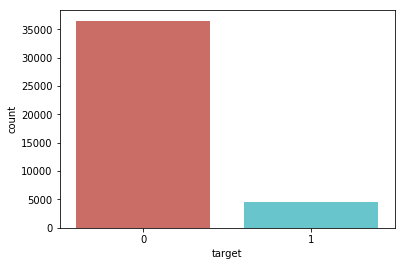

In [4]:
print(bank_clean['target'].value_counts(normalize=True))
sns.countplot(x='target', data=bank_clean, palette='hls', )
plt.show()
# plt.savefig('count_plot')

It appears that we have imbalanced classes. Percentage of non subscription is at 89% while percentage of subscription is only 11%. We will keep this in mind as we perform our analysis and make sure we address the problem. 

Text(0, 0.5, 'Frequency of Purchase')

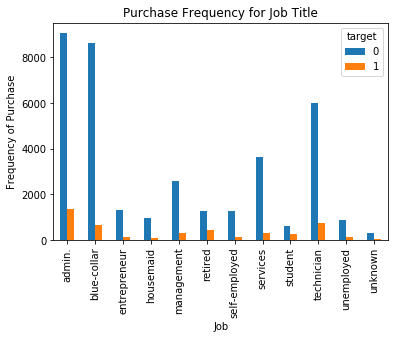

In [5]:
%matplotlib inline
pd.crosstab(bank_clean.job,bank_clean.target).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
# plt.savefig('img/purchase_fre_job')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

what about marital status?

Text(0, 0.5, 'Proportion of Customers')

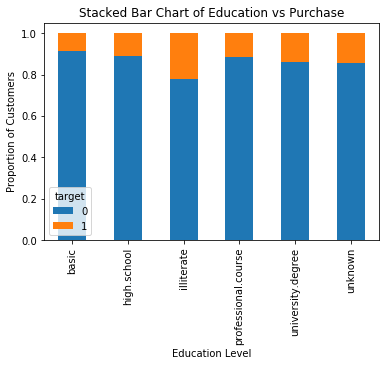

In [6]:
table=pd.crosstab(bank_clean.education,bank_clean.target)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education Level')
plt.ylabel('Proportion of Customers')
# plt.savefig('mariral_vs_pur_stack')

Education seems to be a good predictor of the outcome variable.

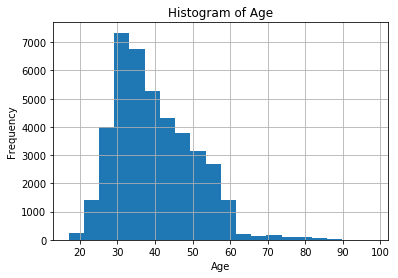

In [7]:
# age distribution
bank_clean.age.hist(bins=20)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency');
# plt.savefig('hist_age')

Most customers in this dataset are between 30 to 40 years old.

## Step 4: Get_ dummies

In [9]:
X = bank_clean.drop('target', axis = 1)
y = bank_clean['target']
X_dum = pd.get_dummies(X, 
               columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'season', 'day_of_week', 'poutcome'], 
               drop_first= True)
print(X_dum.shape)
print(X_dum.columns)
X_dum.head()

(41176, 38)
Index(['age', 'campaign', 'previous', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_married', 'marital_single', 'marital_unknown',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_unknown', 'default_yes',
       'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'season_spring', 'season_summer', 'season_winter',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')


,age,campaign,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,contact_telephone,season_spring,season_summer,season_winter,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,1,0,0,0,1,0,0,0,0,...,1,1,0,0,1,0,0,0,1,0
1,57,1,0,0,0,0,0,0,0,1,...,1,1,0,0,1,0,0,0,1,0
2,37,1,0,0,0,0,0,0,0,1,...,1,1,0,0,1,0,0,0,1,0
3,40,1,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,1,0
4,56,1,0,0,0,0,0,0,0,1,...,1,1,0,0,1,0,0,0,1,0


## Step 5: Train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, random_state = 0, stratify = y, test_size = .2)
print('Train and test datas are split at 80% to 20% ')

Train and test datas are split at 80% to 20% 


In [13]:
print(X_train.shape)
print(y_train.shape)

(32940, 38)
(32940,)


## Step 6: Standard Scaling

In [19]:
# StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
scaled_train = scaler.transform(X_train)
pd.DataFrame(bank_train).shape
## then used 
# scaler.transform(X_test)

(32940, 38)

In [ ]:
dummed_train.head()

## Step 7.1: Dealing with imbalanced classes -- using SMOTE 
we need to up-sample the no-subscription using the SMOTE algorithm(Synthetic Minority Oversampling Techique).
Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.
We are going to implement SMOTE in Python.

In [ ]:
# dealing with over-sampling using SMOTE 
from imblearn.over_sampling import SMOTE 

columns = X_dum.columns

os = SMOTE(random_state=0)
os_data_X, os_data_y = os.fit_sample(X_dum, y)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.Series(os_data_y)

# check numbers
print('Length of oversampled data is', len(os_data_X))
print('Number of no subscription in oversampled data', np.sum(os_data_y==0))
print('Number of subscription', np.sum(os_data_y==1))
print('Proportion of no subscription data in oversampled data is', np.sum(os_data_y==0)/len(os_data_y))
print('Proportion of subscription data in oversampled data is', np.sum(os_data_y==1)/len(os_data_y))

In [ ]:
# print(bank_clean['target'].value_counts(normalize=True))
sns.countplot(x=os_data_y)#, data=bank_clean, palette='hls', )
plt.xlabel('Subscription')
plt.show()

In [ ]:
# after using Synthetic Minority Oversampling Techique
print(os_data_X.shape)
print(len(os_data_y))
os_data_y.value_counts(normalize=True)

## Step 7.2: Using class_weight parameter

In [ ]:
X = bank_clean.drop('target', axis = 1)
y = bank_clean['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, test_size = .2)
print('Train and test datas are split at 80% to 20% ')

In [ ]:
# check the shape of our training data 
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

In [ ]:
y_train.mean()

## Step 4: Modify data for Machine Learning

In [ ]:
X_train.head()

In [ ]:
bank_clean.columns

In [ ]:
dummed_train = pd.get_dummies(X_train, 
               columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'season', 'day_of_week', 'poutcome'], 
               drop_first= True)

In [ ]:
dummed_train.head()
print(dummed_train.shape)
print(dummed_train.columns)

In [ ]:
# calculate for age
mu, std = dummed_train.age.mean(), dummed_train.age.std()
print('mean age', mu, 'age std', std)
print('Standardized value for the first row is:', (dummed_train.age[1233]-mu)/std)
print(dummed_train.age[1233])
dummed_train.head()

## Step 7: Logistic Regression

In [ ]:
## To get our baseline, we'll do a 'vanilla' case - no regularization.
## In this case, we do not scale our data
logreg = LogisticRegression(class_weight='balanced', solver='newton-cg')
logreg.fit(dummed_train, y_train)

In [ ]:
print(logreg.score(dummed_train, y_train))

In [ ]:

#Standard Scaler to be used within pipelines.  
class StScaler(StandardScaler):
    def fit_transform(slf,X,y=None):
        print(f"transformed rows: {len(X)}")
        return super().fit_transform(X,y)

#Using pipeline to avoid data leakage within CV process 
pipe = Pipeline([
    ('scaler', StScaler()),
    ('logreg', LogisticRegression(C = 1e9, 
                                 solver = 'newton-cg',
                                 max_iter = 1000,
                                 class_weight = 'balanced'))
])

print(f"train data length: {len(dummed_train)} rows")
print(cross_val_score(pipe,dummed_train,y_train, cv=5))

## Step 8: Parameter Tuning

In [ ]:
#GridSearchCV for parameter tuning

# param_grid = {''}

# search = GridSearchCV(estimator=pipe,
#                       cv=5,
#                       param_grid=
#                       return_train_score=True)

# search.fit(X_train, y_train)
